In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")


In [ ]:
set_seed()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
folder_path = "./drive/MyDrive/ColabData/"

Random seed set as 42


In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
image_datasets = {x: torchvision.datasets.CIFAR10(
    root=folder_path + "TrainingData",
    train= x == 'train',
    download=True,
    transform=transform
) for x in ['train', 'test']}

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_set_size = int(len(image_datasets['train']) * 0.8)
valid_set_size = len(image_datasets['train']) - train_set_size

_, image_datasets['val'] = torch.utils.data.random_split(image_datasets['train'], [train_set_size, valid_set_size])

In [ ]:
batch_size = 64
dataloaders = {x: torch.utils.data.DataLoader(
    image_datasets[x], 
    batch_size=batch_size, 
) for x in ['train', 'val', 'test']}

In [ ]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
dataset_sizes

{'train': 50000, 'val': 10000, 'test': 10000}

In [ ]:
class_names = image_datasets['train'].classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

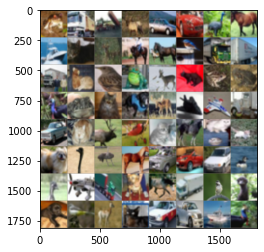

In [ ]:
def imshow(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out)

In [ ]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
AlexNet_model.classifier[6] = nn.Linear(4096,10)
AlexNet_model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(AlexNet_model.parameters(), lr=0.001, momentum=0.9)

Epoch 1/5
----------


KeyboardInterrupt: ignored

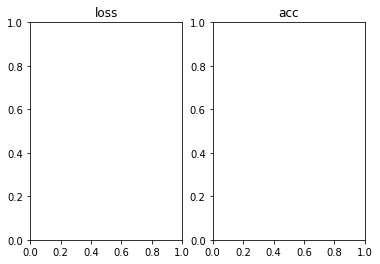

In [ ]:
num_epochs = 5

y_loss = {}
y_loss['train'] = []
y_loss['val'] = []
y_acc = {}
y_acc['train'] = []
y_acc['val'] = []

x_epoch = []
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="acc")


def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    ax1.plot(x_epoch, y_acc['train'], 'bo-', label='train')
    ax1.plot(x_epoch, y_acc['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig(os.path.join(folder_path + 'LossGraphs', f'graghsEpoch{current_epoch}.jpg'))

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'val']:
            if phase == 'train':
                AlexNet_model.train()
            else:
                AlexNet_model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = AlexNet_model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            y_loss[phase].append(epoch_loss)
            y_acc[phase].append(epoch_acc.cpu().numpy())

            if phase == 'val':
                draw_curve(epoch + 1)

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = AlexNet_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {int(100 * correct / total)} %\n')

In [ ]:
torch.save(AlexNet_model.state_dict(), folder_path + 'ModelWeights/model_weights.pth')